In [211]:
# setup library imports
import turicreate as tc
import time, json
import requests
import pandas as pd
import numpy as np
import random
from bs4 import BeautifulSoup
from scipy import spatial

# Introduction

This tutorial will introduce you to recommendation system. There are two main sets of data in this tutorial. For the first part of the tutorial, we will use an existing dataset [MovieLens 100K](https://grouplens.org/datasets/movielens/100k/)
 Since this dataset is pre-processed and has clearer feature matrix, we will use it to study how recommendation system works. For the second part, we will apply the item-item Collaborative filtering on Yelp data to recommend restaurants for users.

# Initial Setup

In this tutorial, we will show how to do some recommendation system in Python using [GraphLab](https://turi.com/products/create/docs/graphlab.toolkits.html)

In order to install Turicreate from GraphLab, you will need to run the following command:

$ pip install turicreate

Also, we'll be using data collected from the [Yelp API](https://www.yelp.com/developers/documentation/v3/get_started)

The MovieLens dataset is loaded here:

In [175]:
#Code reference for MovieLens datasets processing: https://grouplens.org/datasets/movielens/100k/

#Reading users file:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('./ml-100k/u.user', sep='|', names=u_cols, encoding='latin-1')

#Reading ratings file:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('./ml-100k/u.data', sep='\t', names=r_cols, encoding='latin-1')

#Reading items file:
i_cols = ['movie id', 'movie title', 'release date', 'video release date','IMDb URL',
          'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s','Comedy', 'Crime',
          'Documentary', 'Drama', 'Fantasy', 'Film-Noir','Horror', 'Musical', 'Mystery',
          'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items = pd.read_csv('ml-100k/u.item', sep='|', names=i_cols, encoding='latin-1')

#Reading the ratings base file:
ratings_base = pd.read_csv('./ml-100k/ua.base', sep='\t', names=r_cols, encoding='latin-1')

#Reading the ratings test file:
ratings_test = pd.read_csv('./ml-100k/ua.test', sep='\t', names=r_cols, encoding='latin-1')

#Restructuring data into SFrame:
train_data = tc.SFrame(ratings_base)
test_data = tc.SFrame(ratings_test)

# Table of Contents

We will cover the following topics in this tutorial:

* Introduction to recommendation systems
* Popularity model
* Content based recommendation
* Collaborative filtering
* Evaluating collaborative filtering
* Yelp Recommendation System using collaborative filtering

# Introduction to recommendation systems

The key to recommendation systems is how to "recommend". Recommendation system acts like a salesperson. They ask about customer preferences and then recommend the products for customers. There are generally two kinds of recommendation systems: one is uniform recommendation system in which the system recommends same products to each customer; the other is personalized recommendation system in which each customer is given different recommendations. In this tutorial, we will cover both of the two recommendations, with the focus mainly on personalized recommendation system and especially, collaborative filtering algorithm.

# Popularity model

The simplest approach is to recommend items liked by the most number of users. This is a fast approach but has a major drawback: there is no personalization involved with this approach. The most popular items would be same for each user since popularity is defined on the entire user pool.

Simple as this approach may seem, it is still commonly used in places like news portals. For instance, in cnn news, you’ll see a column of “Popular News” which displays the most read articles. This approach works since there is a high chance that a user wants to read the news which is being read the most by others. Here we implement a simple popularity model recommendation system using GraphLab.

In [176]:
#Setting the first n users to apply the popularity recommendation
num_users = 5
selected_users = []
for i in range(1, num_users + 1):
    selected_users.append(i)

#Initiazing the popularity recommender model:
popularity_model = tc.recommender.popularity_recommender.create(train_data, user_id='user_id',
                                                                item_id='movie_id', target='rating')
popularity_recomm = popularity_model.recommend(users=selected_users, k=5)
popularity_recomm.print_rows(num_rows=25)

Recsys training: model = popularity

Warning: Ignoring columns unix_timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 90570 observations with 943 users and 1680 items.

Data prepared in: 0.14064s

90570 observations to process; with 1680 unique items.

+---------+----------+-------+------+
| user_id | movie_id | score | rank |
+---------+----------+-------+------+
|    1    |   1599   |  5.0  |  1   |
|    1    |   1201   |  5.0  |  2   |
|    1    |   1189   |  5.0  |  3   |
|    1    |   1122   |  5.0  |  4   |
|    1    |   814    |  5.0  |  5   |
|    2    |   1599   |  5.0  |  1   |
|    2    |   1201   |  5.0  |  2   |
|    2    |   1189   |  5.0  |  3   |
|    2    |   1122   |  5.0  |  4   |
|    2    |   814    |  5.0  |  5   |
|    3    |   1599   |  5.0  |  1   |
|    3    |   1201   |  5.0  |  2   |
|    3    |   1189   |  5.0  |  3   |
|    3    |   1122   |  5.0  |  4   |
|    3    |   814    |  5.0  |  5   |
|    4    |   1599   |  5.0  |  1   |
|    4    |   1201   |  5.0  |  2   |
|    4    |   1189   |  5.0  |  3   |
|    4    |   1122   |  5.0  |  4   |
|    4    |   814    |  5.0  |  5   |
|    5    |   1599   |  5.0  |  1   |
|    5    |   1201   |  5.0  |  2   |
|    5    |   1189   |  5.0  |  3   |
|    5    | 

We could see from the above example, movies recommended to each user are the same and ordered in same ranking. Also, all movie recommendations fall into the most popular movies with average rating of 5.0

# Content based recommendation

Content based recommendation system looks at what items a user like and recommend the user a "similar" item based on the contents/category of the items. A simple example of this recommendation algorithms is that suppose Person A likes Asian food, the recommendation will recommend all Asian restaurants to him/her. This is not the focus of this tutorial, therefore we will only cover the introduction and will not go deeper into implementing this algorithm.

# Collaborative filtering

Collaborative filtering works as following: let's consider there is a user X. We aim to find a set N of other users whose ratings/preferences are similar to user X's rating/preference. Then we estimate user X's ratings/preferences based on the ratings/preferences of the set N and provide recommendation to user X. For instance, if a person A likes item 1, 2, 3 and B like 2, 3, 4; this implies they have similar interests. Thus A should like item 4 and B should like item 1.

The strength of this algorithm is that it is entirely based on user behavior and independent from the item contents. This makes it more reliable and is the most common approach used in e-commerce websites.

There are mainly two forms of collaborative filtering:

1. User-User Collaborative filtering: Here we look at how users are similar to each other and offer items which were chosen by user B (an user with rating/preferences looking alike user A) to user A. This algorithm is very effective. However, since it requires to compute every user pair information, it takes up a lot of time and computation power. And is hard to scale up when number of users grow dramatically.

2. Item-Item Collaborative filtering: It is quite similar to previous algorithm, but instead of finding customer look alike, we try finding items look alike. Looking through all rating/preferences from each user, we first try to identify similar items. Then for each user, we recommend the items most similar to the items she/he already likes. This algorithm consumes far less resources comparing with the user-user approach. And with fixed number of products, product-product look alike matrix is fixed over time. We will mainly implement item-item collaborative filtering here using GraphLab.

There are generally three ways of defining the similarity matrix and they are listed as below.

## Collaborative Filtering with Jaccard Similarity

Here we will use the following example to illustrate the Jaccard Similarity. In this example, there are 4 users and 7 items. We observe user A and user B both rate item1 and give out a similar rating, this implies A and B might be similar. User A and user C both rate item4 and item5 but gives out very different ratings, this shows A and C might not be similar.

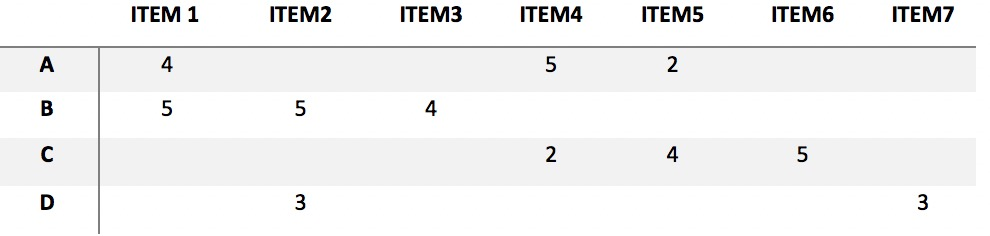

According to the definition, Jaccard Similarity of user A and user B is as below:
sim(A, B) = (# of item both A and B rate)/(# of item A and B rate in total)
In this example sim(A, B) = 1/5, sim(A, C) = 2/4. This means A and C has higher Jaccard Similarity in this example, which is counter intuitive. This also implies Jaccard Similarity is not situable for analyzing the similarity when users give out non-binary ratings to items since it ignores rating values. But jaccard similarity may apply when users give out binary like/dislike rating to items.

Here we also give out an example on how to use Jaccard Similarity. We could see the recommendation results are now personalized, but from the above analysis we could also draw the conclusion that the Jaccard Similarity is not the optimal model for collaborative filtering with rating values.

In [178]:
#Train Model using item-item Jaccard Similarity
item_sim_model_jaccard = tc.recommender.item_similarity_recommender.create(train_data,
                user_id='user_id', item_id='movie_id', target='rating', similarity_type='jaccard')
item_sim_recomm_jaccard = item_sim_model_jaccard.recommend(users=selected_users, k=5)
item_sim_recomm_jaccard.print_rows(num_rows=25)

Recsys training: model = item_similarity

Warning: Ignoring columns unix_timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 90570 observations with 943 users and 1680 items.

Data prepared in: 0.145341s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 9.724ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 21.937ms                            | 0                | 0               |

| 120.063ms                           | 100              | 1680            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.136094s

+---------+----------+---------------------+------+
| user_id | movie_id |        score        | rank |
+---------+----------+---------------------+------+
|    1    |   423    |  0.1666922933272733 |  1   |
|    1    |   568    |  0.1563204335802384 |  2   |
|    1    |   202    | 0.15332082710193315 |  3   |
|    1    |   403    | 0.14992555953164138 |  4   |
|    1    |   385    | 0.14855115468265445 |  5   |
|    2    |    7     |  0.1617042330595163 |  1   |
|    2    |   121    |  0.1599736248071377 |  2   |
|    2    |   181    | 0.15784773574425623 |  3   |
|    2    |    50    | 0.15625400038865897 |  4   |
|    2    |   117    | 0.15463673839202294 |  5   |
|    3    |   328    | 0.12468654459173029 |  1   |
|    3    |   313    |  0.1013359698382291 |  2   |
|    3    |   332    | 0.10127936574545773 |  3   |
|    3    |    12    | 0.10076934911987999 |  4   |
|    3    |   245    | 0.09754122251814062 |  5   |
|    4    |   121    |  0.1560882500239781 |  1   |
|    4    | 

## Collaborative Filtering with Cosine Similarity

Here, we still use the previous example to illustrate cosine similarity. We represent user A, B and C using vectors below and assume the ratings are 0 for items they haven't rated yet. Then we compute the cosine similarity between vector A and vector B to get the similarity between user A and B.

In [151]:
vector_A = np.array([4, 0, 0, 5, 1, 0, 0])
vector_B = np.array([5, 5, 4, 0, 0, 0, 0])
vector_C = np.array([0, 0, 0, 2, 4, 5, 0])
cos_sim_A_B = 1 - spatial.distance.cosine(vector_A, vector_B)
cos_sim_A_C = 1 - spatial.distance.cosine(vector_A, vector_C)
print("Cosine Similarity A and B:", cos_sim_A_B)
print("Cosine Similarity A and C:", cos_sim_A_C)

Cosine Similarity A and B: 0.379868588199
Cosine Similarity A and C: 0.32203059436


We could see here A and B are more similar than A and C using cosine similarity. This solves the problem with Jaccard Similarity. Here we also give out an example on how to use Cosine Similarity using GraphLab.

In [179]:
#Train Model using item-item Cosine Similarity
item_sim_model_cosine = tc.recommender.item_similarity_recommender.create(train_data,
                user_id='user_id', item_id='movie_id', target='rating', similarity_type='cosine')
item_sim_recomm_cosine = item_sim_model_cosine.recommend(users=selected_users, k=5)
item_sim_recomm_cosine.print_rows(num_rows=25)

Recsys training: model = item_similarity

Warning: Ignoring columns unix_timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 90570 observations with 943 users and 1680 items.

Data prepared in: 0.141515s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 8.685ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 18.995ms                            | 0.25             | 6               |

| 147.157ms                           | 100              | 1680            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.153608s

+---------+----------+--------------------+------+
| user_id | movie_id |       score        | rank |
+---------+----------+--------------------+------+
|    1    |   423    | 0.9834008066708805 |  1   |
|    1    |   202    | 0.9495907992352056 |  2   |
|    1    |   655    | 0.7928164253253063 |  3   |
|    1    |   403    | 0.765623665037956  |  4   |
|    1    |   568    | 0.7512945396299581 |  5   |
|    2    |    50    | 1.1256258487701416 |  1   |
|    2    |   181    | 1.0651773168490484 |  2   |
|    2    |    7     | 0.9998190838557023 |  3   |
|    2    |   121    |  0.94162796323116  |  4   |
|    2    |    9     | 0.831989913032605  |  5   |
|    3    |   313    | 0.6353766620159149 |  1   |
|    3    |   328    | 0.6032880300825293 |  2   |
|    3    |   315    | 0.5422587123784152 |  3   |
|    3    |   331    | 0.5355071858926252 |  4   |
|    3    |   332    | 0.5316696112806146 |  5   |
|    4    |    50    | 1.1311477082116264 |  1   |
|    4    |   288    | 1.048715

However, there is still a potential issue for Cosine Similarity is that we assume users rate 0 (negatively against the item) for items they haven't rated yet. We will further modify the model using centered cosine, in other words, the Pearson Correlation.

## Collaborative Filtering with Pearson Similarity

Here, we introduce pearson similarity which calculates Pearson Correlation between two vectors. Pearson Correlation is also called the centered cosine between two vectors. Using the example above, we first normalize the ratings by subtracting the row mean. For instance, the row mean for User A is (4+5+1)/3 = 10/3. Therefore, the ratings for User A is normalized to (4-10/3) = 2/3 for item1, (5-10/3) = 5/3 for item14 and (1-10/3) = -7/3 for item5. Following similar logic, the normalized vectors for A, B and C are as follows.

In [153]:
vector_A = np.array([2/3, 0, 0, 5/3, -7/3, 0, 0])
vector_B = np.array([1/3, 1/3, -2/3, 0, 0, 0, 0])
vector_C = np.array([0, 0, 0, -5/3, 1/3, 4/3, 0])
pearson_sim_A_B = 1 - spatial.distance.cosine(vector_A, vector_B)
pearson_sim_A_C = 1 - spatial.distance.cosine(vector_A, vector_C)
print("Pearson Similarity A and B:", pearson_sim_A_B)
print("Pearson Similarity A and C:", pearson_sim_A_C)

Pearson Similarity A and B: 0.0924500327042
Pearson Similarity A and C: -0.559085246252


From this example, we could conclude in this setting Pearson similarity catches our intuition better. This is because it treats missing ratings as average and scales all ratings around the average: 0.

Here we also give out an example on how to use Pearson Similarity using GraphLab.

In [194]:
#Train Model using item-item Pearson Similarity
item_sim_model_pearson = tc.recommender.item_similarity_recommender.create(train_data,
                user_id='user_id', item_id='movie_id', target='rating', similarity_type='pearson')
item_sim_recomm_pearson = item_sim_model_pearson.recommend(users=selected_users, k=30)
item_sim_recomm_pearson.print_rows(num_rows=150)

Recsys training: model = item_similarity

Warning: Ignoring columns unix_timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 90570 observations with 943 users and 1680 items.

Data prepared in: 0.13896s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 6.247ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 20.285ms                            | 0.25             | 6               |

| 323.083ms                           | 100              | 1680            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.343393s

+---------+----------+--------------------+------+
| user_id | movie_id |       score        | rank |
+---------+----------+--------------------+------+
|    1    |   1500   |        5.0         |  1   |
|    1    |   1201   |        5.0         |  2   |
|    1    |   814    |        5.0         |  3   |
|    1    |   1122   |        5.0         |  4   |
|    1    |   1189   |        5.0         |  5   |
|    1    |   1536   |        5.0         |  6   |
|    1    |   1467   |        5.0         |  7   |
|    1    |   1656   |        5.0         |  8   |
|    1    |   1599   |        5.0         |  9   |
|    1    |   1293   |        5.0         |  10  |
|    1    |   1449   | 4.716636559922926  |  11  |
|    1    |   1642   | 4.5010239400026455 |  12  |
|    1    |   1398   |        4.5         |  13  |
|    1    |   1463   |        4.5         |  14  |
|    1    |   1594   | 4.4994249953568435 |  15  |
|    1    |   408    | 4.482689862820377  |  16  |
|    1    |   318    | 4.476015

Interestingly, we could see the results are messed up and not what we have expected. This is because by using the pearson similarity, there are all zero vectors for popular movies and the cosine silimarity between an all zero vector and another vector has no meaning. For instance, suppose item1 with 5 users in the model, originally item1's vector is (5, 5, 0, 0, 5). After normalization, it becomes (0, 0, 0, 0, 0) which makes no sense in calculating cosine similarity. This is the potential reason why Pearson Similarity shows weird results here.

# Evaluating collaborative filtering algorithms

Here, we will evaluate collaborative filtering algorithms mainly using the idea of precision and recall.

* Recall:
This means the ratio of items that a user likes/rates high were actually recommended.
For instance, if a user likes 5 items and the recommendation decided to show 3 of them, then the recall is 0.6
One thing tricky about recall is that we can have 100% recall is we simply recommend all items. But in this way, we will be penalized by the precision ratio.

* Precision:
This means out of all the recommended items, how many the user actually liked.
For instance, if 5 items were recommended to the user and he liked 4 of them, then precision is 0.8

In GraphLab, there is a build-in method to evaluate recommendation models using precision and recall. Since we mentioned Jaccard similarity is not suitable for recommendation systems with rating values. We will only evaluate the Cosine similarity and pearson similarity model here.

In [198]:
#Evaluate the train model
compare_performance = tc.recommender.util.compare_models(test_data, [item_sim_model_cosine, item_sim_model_pearson])
print(compare_performance)

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+----------------------+---------------------+
| cutoff |     mean_recall      |    mean_precision   |
+--------+----------------------+---------------------+
|   1    | 0.008483563096500545 |  0.0848356309650053 |
|   2    | 0.016224814422057282 |  0.0811240721102863 |
|   3    | 0.021208907741251313 | 0.07069635913750438 |
|   4    | 0.02693531283138921  | 0.06733828207847306 |
|   5    | 0.03181336161187693  | 0.06362672322375386 |
|   6    | 0.04008483563096504  | 0.06680805938494164 |
|   7    | 0.04623541887592789  | 0.06605059839418269 |
|   8    | 0.05196182396606571  | 0.06495227995758224 |
|   9    | 0.05715800636267231  | 0.06350889595852487 |
|   10   |  0.0643690349946978  |  0.0643690349946978 |
+--------+----------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.3611922410203454

Per User RMSE (best)
+---------+-------------------+-------+
| user_id |       

The precision and recall summary of the two models are as following:

Precision and recall for Cosine Similarity:

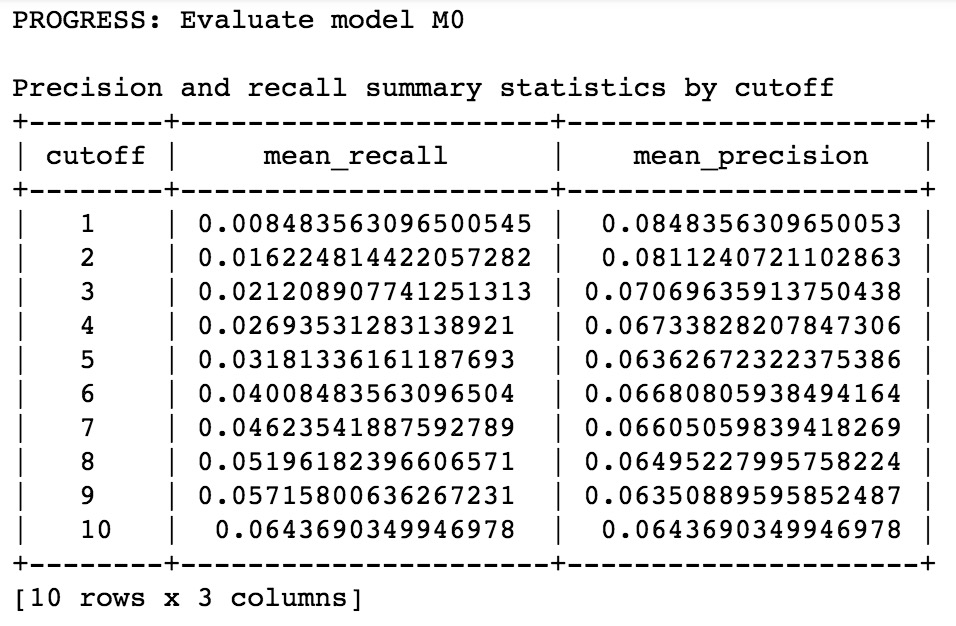

Precision and recall for Pearson Similarity:

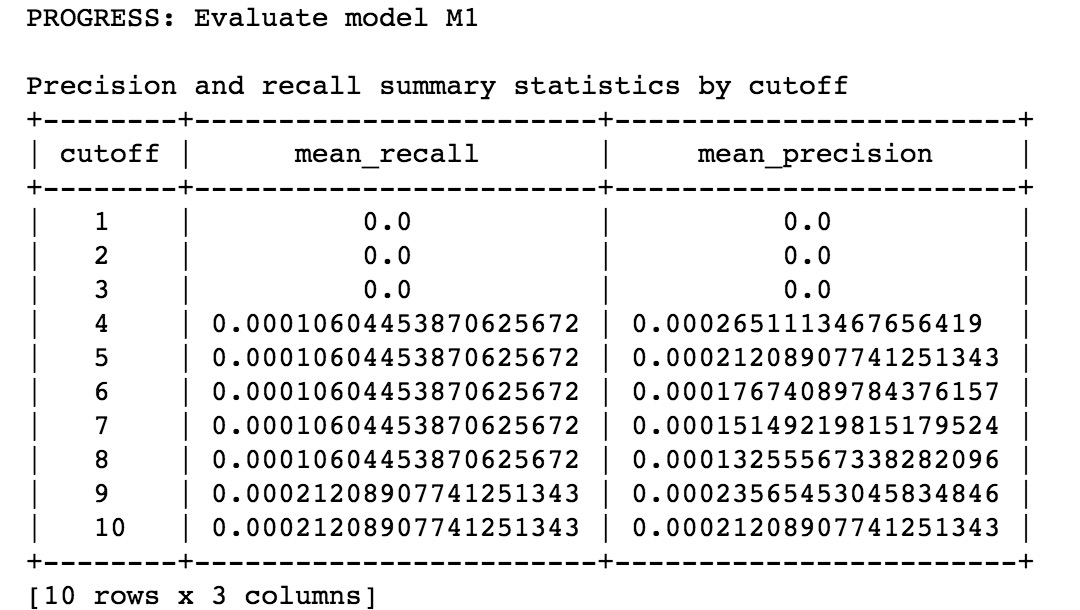

We can conclude that in [MovieLens 100K](https://turi.com/products/create/docs/graphlab.toolkits.html) dataset, cosine similarity is a better recommendation model with both higher precision and higher recall. This also matches our above analysis.

# Yelp Recommendation System using Collaborative Filtering

Now, we move on to implement a recommendation system for Yelp. Here we train the recommendation system on user's rating data for the top 10 restaurants in Shadyside, Pittsburgh. The scale of our training dataset is around 4,000. First, we extract the restaurant information using the Yelp API.

In [199]:
# Getting the API key
def read_api_key(filepath):
    with open('api_key.txt', 'r') as f:
        return f.read().replace('\n','')

# Getting a full restaurant list in a neighborhood
def all_restaurants(api_key, query):
    head = {"authorization": "Bearer %s" % api_key}    
    response_init = requests.get("https://api.yelp.com/v3/businesses/search",
                    headers = head, params={"categories": "restaurants", "location": query,"offset": 0, "limit": 20})
    json_result = json.loads(response_init.text)
    total = 0
    if 'total' in json_result.keys():
        total = int(json_result['total'])
    list_result = []
    for i in range(0, total, 20):
        response_new = requests.get("https://api.yelp.com/v3/businesses/search", headers = head, 
                       params={"categories": "Restaurants", "location": query, "offset": i, "limit": 20})
        json_result = json.loads(response_new.text)
        list_new = json_result['businesses']
        list_result.extend(list_new)
        time.sleep(0.5)
    return list_result

api_key = read_api_key('./api_key.txt')
all_restaurant_shadyside = all_restaurants(api_key, 'Shadyside, Pittsburgh')

# Number of restaurants is n, can be tuned for larger scale analysis
n = 10

# List of restaurants and url for the restaurants
restaurant_list_raw = all_restaurant_shadyside[:n]
restaurant_list = []
restaurant_url_list = []
for x in range(0, n):
    restaurant_list.append(restaurant_list_raw[x]['name'])
    restaurant_url_list.append(restaurant_list_raw[x]['url'])
print(restaurant_list)
print(restaurant_url_list)

['Noodlehead', "Millie's Homemade Ice Cream", 'Casbah', "Mercurio's", 'Spoon', "P&G's Pamela's Diner", 'Soba', 'Harris Grill', 'Senyai Thai Kitchen', 'Cafe Moulin']
['https://www.yelp.com/biz/noodlehead-pittsburgh?adjust_creative=R-EwPFXrdCzzOYl0M6aOWg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=R-EwPFXrdCzzOYl0M6aOWg', 'https://www.yelp.com/biz/millies-homemade-ice-cream-pittsburgh?adjust_creative=R-EwPFXrdCzzOYl0M6aOWg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=R-EwPFXrdCzzOYl0M6aOWg', 'https://www.yelp.com/biz/casbah-pittsburgh?adjust_creative=R-EwPFXrdCzzOYl0M6aOWg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=R-EwPFXrdCzzOYl0M6aOWg', 'https://www.yelp.com/biz/mercurios-pittsburgh?adjust_creative=R-EwPFXrdCzzOYl0M6aOWg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=R-EwPFXrdCzzOYl0M6aOWg', 'https://www.yelp.com/biz/spoon-pittsburgh?adjust_creative=R-EwPFXrdCzzOYl0M6aOWg&utm_campaign=

Next, we will get the user rating information from the restaurants listed above to train and test a collaborative filtering recommendation system. This will contain three lists for each training and testing dataframe: one list for userid, one list for ratings and the other list for restaurants. We will also randomly pick some of the data from the dataset to form the test dataset.

Note: the following block of codes will take longer (around 15 mins) to execute since it needs to get data from hundreds of Yelp pages, please avoid running this block of codes to save time.

In [208]:
# Getting data from a single html page
def get_data_from_single_html(html):
    result = ()
    root = BeautifulSoup(html,"lxml")
    div_all = root.findAll("div", "review review--with-sidebar")
    list_result = []
    href_next_page = ""
    for div in div_all:
        dict_each = {}
        dict_each["user_id"] = str(div.attrs['data-signup-object'][8:])
        sub_div = div.find("div", attrs={"class": "biz-rating biz-rating-large clearfix"})
        dict_each["rating"] = float(sub_div.contents[1].contents[1].attrs['title'][:3])
        list_result.append(dict_each)
    div_current_page = root.find("div", "arrange_unit page-option current")
    div_next_page = div_current_page.find_next_sibling("div")
    if div_next_page is None:
        href_next_page = "None"
    else:
        atag_next_page = div_next_page.find("a", "available-number pagination-links_anchor")
        href_next_page = str(atag_next_page.attrs['href'])
    result = result + (list_result, href_next_page)
    return result

# Getting all data needed from a restaurant
def extract_data(url, rest_name):
    list_result = []
    list_user = []
    list_rating = []
    list_item = []
    url_current = url
    cur_page_result = get_data_from_single_html(requests.get(url_current).text)
    while cur_page_result[1] != 'None':
        list_result.extend(cur_page_result[0])
        url_current = cur_page_result[1]
        cur_page_result = get_data_from_single_html(requests.get(url_current).text)
    assert cur_page_result[1] == 'None'
    list_result.extend(cur_page_result[0])
    for each_one in list_result:
        list_user.append(each_one['user_id'])
        list_rating.append(each_one['rating'])
        list_item.append(rest_name)
    return (list_user, list_rating, list_item)

# Forming dataset for testing and training, check the length of three lists to ensure accuracy
list_user = []
list_rating = []
list_item = []
for i in range(0, 10):
    list_user.extend(extract_data(restaurant_url_list[i], restaurant_list[i])[0])
    list_rating.extend(extract_data(restaurant_url_list[i], restaurant_list[i])[1])
    list_item.extend(extract_data(restaurant_url_list[i], restaurant_list[i])[2])
print("Length for list user", len(list_user))
print("Length for list rating", len(list_rating))
print("Length for list item", len(list_item))

/anaconda3/lib/python3.5/site-packages/bs4/builder/_lxml.py:250: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  self.parser.feed(markup)


Length for list user 3239
Length for list rating 3239
Length for list item 3239


Now that we have three lists for users, rating and items(restaurants), we can now use these information to form the train dataframe and the test dataframe for our recommendation system.

In [213]:
# Get a list of x random integers from 0 to n
# Setting seed to ensure same random code for each run
random.seed(9001)
def get_random_number_list(n, x):
    list_result = random.sample(range(0, n), x)
    return list_result

# pick 20% of data as test dataset
list_random = get_random_number_list(len(list_user), 648)

# Generate test and train sets
def generate_train_test_data(list1, list2, list3):
    list_user_train = []
    list_rating_train = []
    list_item_train = []
    list_user_test = []
    list_rating_test = []
    list_item_test = []
    for i in range(0, len(list1)):
        if i in list_random:
            list_user_test.append(list1[i])
            list_rating_test.append(list2[i])
            list_item_test.append(list3[i])
        else:
            list_user_train.append(list1[i])
            list_rating_train.append(list2[i])
            list_item_train.append(list3[i])
    
    sf_train = tc.SFrame({'user_id': list_user_train, 'item_id': list_item_train, 'rating': list_rating_train})
    sf_test = tc.SFrame({'user_id': list_user_test, 'item_id': list_item_test, 'rating': list_rating_test})
    
    return (sf_train, sf_test)

dataset_all = generate_train_test_data(list_user, list_rating, list_item)
dataset_train = dataset_all[0]
dataset_test = dataset_all[1]
print("Dataframe for train set:")
print(dataset_train.head())
print(dataset_train.shape)
print("Dataframe for test set:")
print(dataset_test.head())
print(dataset_test.shape)

Dataframe for train set:
+------------+--------+------------------------+
|  item_id   | rating |        user_id         |
+------------+--------+------------------------+
| Noodlehead |  5.0   | GODifnlmYoFbPbB6INk5VA |
| Noodlehead |  4.0   | wRtDGmMriHBQSfqW15szJQ |
| Noodlehead |  5.0   | 7wAdctG3920KcBLSVXlZdQ |
| Noodlehead |  5.0   | zg6LAy9gGLVH9JtcYP9gJg |
| Noodlehead |  5.0   | oc3344f0uSGQ-KrApW1xVw |
| Noodlehead |  4.0   | 0BxF-X_WBAoL6Zk46RzhYQ |
| Noodlehead |  4.0   | EaRd_4nFnPs8Fei-H2ZmVA |
| Noodlehead |  4.0   | 538pVFWMOaaRbmW0AXZy4Q |
| Noodlehead |  5.0   | j_XUyKHWIaTJwxRFqNgsxg |
| Noodlehead |  5.0   | cKeMks0yFeItSlkUKnZW0w |
+------------+--------+------------------------+
[10 rows x 3 columns]

(2591, 3)
Dataframe for test set:
+------------+--------+------------------------+
|  item_id   | rating |        user_id         |
+------------+--------+------------------------+
| Noodlehead |  4.0   | fhAk9y00oF5yvXwn8gl3JQ |
| Noodlehead |  5.0   | DosPs0fkIbXO

After getting the test and train datasets, we now apply the collaborative filtering algorithm using Cosine Similarity and Pearson Similarity. We will also evaluate the precision and recall for the two models.

In [223]:
# the cosine similarity model:
item_sim_model_cosine_yelp = tc.recommender.item_similarity_recommender.create(dataset_train,
                                        target='rating', similarity_type='cosine')
item_sim_recomm_cosine = item_sim_model_cosine_yelp.recommend(k=5)
item_sim_recomm_cosine.print_rows(num_rows=25)

Recsys training: model = item_similarity

Preparing data set.

Data has 2591 observations with 2108 users and 10 items.

Data prepared in: 0.013977s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 591us                          | 47.25      |

| 1.106ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 1.541ms                             | 0                | 0               |

| 2.857ms                             | 100              | 10              |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.005452s

+------------------------+-----------------------------+---------------------+------+
|        user_id         |           item_id           |        score        | rank |
+------------------------+-----------------------------+---------------------+------+
| GODifnlmYoFbPbB6INk5VA | Millie's Homemade Ice Cream |  0.701056718826294  |  1   |
| GODifnlmYoFbPbB6INk5VA |         Harris Grill        | 0.41298508644104004 |  2   |
| GODifnlmYoFbPbB6INk5VA |            Casbah           |  0.3542092442512512 |  3   |
| GODifnlmYoFbPbB6INk5VA |             Soba            |  0.345996618270874  |  4   |
| GODifnlmYoFbPbB6INk5VA |         Cafe Moulin         | 0.31711310148239136 |  5   |
| wRtDGmMriHBQSfqW15szJQ | Millie's Homemade Ice Cream |  0.5608453750610352 |  1   |
| wRtDGmMriHBQSfqW15szJQ |         Harris Grill        | 0.33038806915283203 |  2   |
| wRtDGmMriHBQSfqW15szJQ |            Casbah           |  0.283367395401001  |  3   |
| wRtDGmMriHBQSfqW15szJQ |             Soba           

recommendations finished on 1000/2108 queries. users per second: 52265.7

recommendations finished on 2000/2108 queries. users per second: 79317.9

In [220]:
# the pearson similarity model:
item_sim_model_pearson_yelp = tc.recommender.item_similarity_recommender.create(dataset_train,
                                        target='rating', similarity_type='pearson')
item_sim_recomm_pearson = item_sim_model_pearson_yelp.recommend(k=5)
item_sim_recomm_cosine.print_rows(num_rows=25)

Recsys training: model = item_similarity

Preparing data set.

Data has 2591 observations with 2108 users and 10 items.

Data prepared in: 0.012505s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 8.057ms                        | 94.75      |

| 8.594ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 9.078ms                             | 0                | 0               |

| 9.826ms                             | 100              | 10              |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.012693s

recommendations finished on 1000/2108 queries. users per second: 40464.5

recommendations finished on 2000/2108 queries. users per second: 40680.2

+------------------------+-----------------------------+---------------------+------+
|        user_id         |           item_id           |        score        | rank |
+------------------------+-----------------------------+---------------------+------+
| GODifnlmYoFbPbB6INk5VA | Millie's Homemade Ice Cream |  0.701056718826294  |  1   |
| GODifnlmYoFbPbB6INk5VA |         Harris Grill        | 0.41298508644104004 |  2   |
| GODifnlmYoFbPbB6INk5VA |            Casbah           |  0.3542092442512512 |  3   |
| GODifnlmYoFbPbB6INk5VA |             Soba            |  0.345996618270874  |  4   |
| GODifnlmYoFbPbB6INk5VA |         Cafe Moulin         | 0.31711310148239136 |  5   |
| wRtDGmMriHBQSfqW15szJQ | Millie's Homemade Ice Cream |  0.5608453750610352 |  1   |
| wRtDGmMriHBQSfqW15szJQ |         Harris Grill        | 0.33038806915283203 |  2   |
| wRtDGmMriHBQSfqW15szJQ |            Casbah           |  0.283367395401001  |  3   |
| wRtDGmMriHBQSfqW15szJQ |             Soba           

Finally, we will evaluate the two methods: cosine similarity and pearson similarity to see which one provides a better recommendation for our dataset.

In [221]:
#Evaluate the model
compare_performance = tc.recommender.util.compare_models(dataset_test,
                    [item_sim_model_cosine_yelp, item_sim_model_pearson_yelp])
print(compare_performance)

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |     mean_recall     |    mean_precision   |
+--------+---------------------+---------------------+
|   1    | 0.13710121012101195 | 0.15016501650165004 |
|   2    | 0.23789878987898788 | 0.13201320132013214 |
|   3    | 0.33044554455445546 | 0.12156215621562153 |
|   4    |  0.4357810781078106 | 0.11922442244224417 |
|   5    |  0.5141639163916393 | 0.11196369636963696 |
|   6    |  0.606573157315732  |  0.110038503850385  |
|   7    |  0.6710671067106708 | 0.10552019487663046 |
|   8    |  0.8814631463146307 |  0.1206958195819583 |
|   9    |  0.9595709570957096 | 0.11897689768976898 |
|   10   |         1.0         |  0.1158599193252658 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 4.143581817799672

Per User RMSE (best)
+------------------------+--------------------+-------+
|        user_id 

From the above results, we observe that the results for Cosine Similarity and Pearson Similarity are quite similar to each other. Still, mean_precision of Cosine Similarity collaborative filtering is slightly higher than that of Pearson Similarity. This implies Cosine Similarity model produces better results for this dataset.

# Summary

In this tutorial, we cover the basics for recommendation systems and implement an item-item collaborative filtering on Yelp. Some thoughts on this tutorial is that we only use a small dataset with 10 restaurants for a snippet of what this recommendation looks like. With a small number of items, the recommended results are concentrated on several restaurants. Future inspiration will be extracting the full dataset from Yelp to generate more diversified and personalized recommendation results.

# References

* [MovieLens 100K](https://grouplens.org/datasets/movielens/100k/)
* [GraphLab](https://turi.com/products/create/docs/graphlab.toolkits.html)
* [Yelp API](https://www.yelp.com/developers/documentation/v3/get_started)